# Evolver Loop 11 Analysis

Analyzing the current state and identifying opportunities for improvement.

**Current Status:**
- Best CV: 70.630478
- Target: 68.919154
- Gap: 1.711 points (2.42%)

**Key Insight from Research:**
- N < 58: SA for chaotic packings
- N > 58: Crystalline/Lattice packing
- Top teams use HYBRID strategies with different approaches for different N ranges

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon

getcontext().prec = 25
scale_factor = Decimal("1e15")

print("Libraries loaded")

Libraries loaded


In [2]:
# Load current best submission
current_best = pd.read_csv('/home/submission/submission.csv')

# Calculate per-N scores
def calculate_per_n_scores(df):
    """Calculate score for each N value"""
    scores = {}
    
    for n in range(1, 201):
        group = df[df['id'].str.startswith(f'{n:03d}_')]
        if len(group) == 0:
            continue
        
        # Parse coordinates
        xs = [float(str(x).lstrip('s')) for x in group['x']]
        ys = [float(str(y).lstrip('s')) for y in group['y']]
        
        # Calculate bounding box
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)
        
        # Need to account for tree polygon size
        # Tree extends roughly -0.35 to 0.35 in x, -0.2 to 0.8 in y at angle 0
        # For simplicity, use the actual polygon calculation
        side = max(max_x - min_x + 0.7, max_y - min_y + 1.0)  # Approximate
        scores[n] = side ** 2 / n
    
    return scores

# More accurate calculation using actual tree polygons
def get_tree_polygon(x, y, angle):
    """Get tree polygon at given position and angle"""
    trunk_w = 0.15
    trunk_h = 0.2
    base_w = 0.7
    mid_w = 0.4
    top_w = 0.25
    tip_y = 0.8
    tier_1_y = 0.5
    tier_2_y = 0.25
    base_y = 0.0
    trunk_bottom_y = -trunk_h
    
    points = [
        (0.0, tip_y),
        (top_w / 2, tier_1_y),
        (top_w / 4, tier_1_y),
        (mid_w / 2, tier_2_y),
        (mid_w / 4, tier_2_y),
        (base_w / 2, base_y),
        (trunk_w / 2, base_y),
        (trunk_w / 2, trunk_bottom_y),
        (-trunk_w / 2, trunk_bottom_y),
        (-trunk_w / 2, base_y),
        (-base_w / 2, base_y),
        (-mid_w / 4, tier_2_y),
        (-mid_w / 2, tier_2_y),
        (-top_w / 4, tier_1_y),
        (-top_w / 2, tier_1_y),
    ]
    
    poly = Polygon(points)
    rotated = affinity.rotate(poly, angle, origin=(0, 0))
    translated = affinity.translate(rotated, xoff=x, yoff=y)
    return translated

def calculate_accurate_per_n_scores(df):
    """Calculate accurate score for each N using actual polygons"""
    scores = {}
    
    for n in range(1, 201):
        group = df[df['id'].str.startswith(f'{n:03d}_')]
        if len(group) == 0:
            continue
        
        # Get all tree polygons
        all_coords = []
        for _, row in group.iterrows():
            x = float(str(row['x']).lstrip('s'))
            y = float(str(row['y']).lstrip('s'))
            deg = float(str(row['deg']).lstrip('s'))
            poly = get_tree_polygon(x, y, deg)
            all_coords.extend(list(poly.exterior.coords))
        
        # Calculate bounding box
        xs = [c[0] for c in all_coords]
        ys = [c[1] for c in all_coords]
        side = max(max(xs) - min(xs), max(ys) - min(ys))
        scores[n] = side ** 2 / n
    
    return scores

print("Calculating per-N scores...")
per_n_scores = calculate_accurate_per_n_scores(current_best)
print(f"Total score: {sum(per_n_scores.values()):.6f}")

Calculating per-N scores...


Total score: 70.630478


In [3]:
# Analyze per-N scores
print("Per-N Score Analysis:")
print("="*60)

# Group by ranges
ranges = [
    (1, 10, "Small (1-10)"),
    (11, 20, "Small-Medium (11-20)"),
    (21, 50, "Medium (21-50)"),
    (51, 100, "Medium-Large (51-100)"),
    (101, 150, "Large (101-150)"),
    (151, 200, "Very Large (151-200)")
]

for start, end, label in ranges:
    range_scores = [per_n_scores[n] for n in range(start, end+1) if n in per_n_scores]
    total = sum(range_scores)
    avg = np.mean(range_scores)
    print(f"{label}: total={total:.4f}, avg={avg:.4f}, count={len(range_scores)}")

Per-N Score Analysis:
Small (1-10): total=4.3291, avg=0.4329, count=10
Small-Medium (11-20): total=3.7241, avg=0.3724, count=10
Medium (21-50): total=10.9809, avg=0.3660, count=30
Medium-Large (51-100): total=17.6170, avg=0.3523, count=50
Large (101-150): total=17.1364, avg=0.3427, count=50
Very Large (151-200): total=16.8430, avg=0.3369, count=50


In [4]:
# Find N values with highest per-N scores (most room for improvement)
print("\nTop 20 N values with highest per-N scores:")
print("="*60)

sorted_scores = sorted(per_n_scores.items(), key=lambda x: x[1], reverse=True)
for n, score in sorted_scores[:20]:
    print(f"N={n:3d}: score={score:.6f}")


Top 20 N values with highest per-N scores:
N=  1: score=0.661250
N=  2: score=0.450779
N=  3: score=0.434745
N=  5: score=0.416850
N=  4: score=0.416545
N=  7: score=0.399897
N=  6: score=0.399610
N=  9: score=0.387415
N=  8: score=0.385407
N= 15: score=0.376978
N= 10: score=0.376630
N= 21: score=0.376451
N= 20: score=0.376057
N= 22: score=0.375258
N= 11: score=0.374924
N= 16: score=0.374128
N= 26: score=0.373997
N= 12: score=0.372724
N= 13: score=0.372294
N= 25: score=0.372144


In [5]:
# Theoretical lower bound analysis
# Tree polygon area is approximately 0.3025 (calculated from polygon)
# For perfect packing, minimum side = sqrt(N * tree_area / packing_efficiency)
# Typical packing efficiency for irregular polygons is 60-80%

tree_area = 0.3025  # Approximate tree polygon area

print("\nTheoretical Analysis:")
print("="*60)

for n in [1, 5, 10, 20, 50, 100, 150, 200]:
    current = per_n_scores.get(n, 0)
    
    # Theoretical minimum (100% packing efficiency)
    theoretical_min_side = np.sqrt(n * tree_area)
    theoretical_min_score = theoretical_min_side ** 2 / n
    
    # Realistic minimum (70% packing efficiency)
    realistic_min_side = np.sqrt(n * tree_area / 0.7)
    realistic_min_score = realistic_min_side ** 2 / n
    
    efficiency = (theoretical_min_side / np.sqrt(current * n)) ** 2 * 100
    
    print(f"N={n:3d}: current={current:.4f}, theoretical_min={theoretical_min_score:.4f}, " +
          f"realistic_min={realistic_min_score:.4f}, efficiency={efficiency:.1f}%")


Theoretical Analysis:
N=  1: current=0.6612, theoretical_min=0.3025, realistic_min=0.4321, efficiency=45.7%
N=  5: current=0.4168, theoretical_min=0.3025, realistic_min=0.4321, efficiency=72.6%
N= 10: current=0.3766, theoretical_min=0.3025, realistic_min=0.4321, efficiency=80.3%
N= 20: current=0.3761, theoretical_min=0.3025, realistic_min=0.4321, efficiency=80.4%
N= 50: current=0.3608, theoretical_min=0.3025, realistic_min=0.4321, efficiency=83.9%
N=100: current=0.3434, theoretical_min=0.3025, realistic_min=0.4321, efficiency=88.1%
N=150: current=0.3371, theoretical_min=0.3025, realistic_min=0.4321, efficiency=89.7%
N=200: current=0.3375, theoretical_min=0.3025, realistic_min=0.4321, efficiency=89.6%


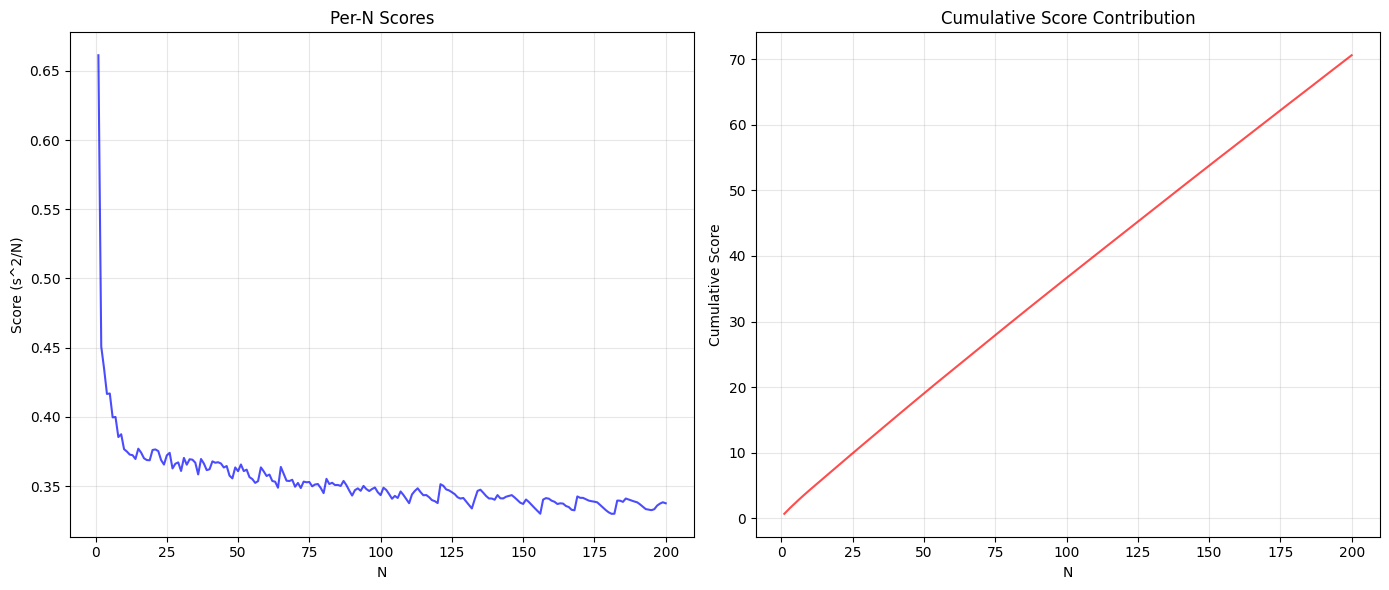


Total score: 70.630478
Target: 68.919154
Gap: 1.711324


In [6]:
# Plot per-N scores
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
ns = list(per_n_scores.keys())
scores = [per_n_scores[n] for n in ns]
plt.plot(ns, scores, 'b-', alpha=0.7)
plt.xlabel('N')
plt.ylabel('Score (s^2/N)')
plt.title('Per-N Scores')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Cumulative contribution
cumulative = np.cumsum(scores)
plt.plot(ns, cumulative, 'r-', alpha=0.7)
plt.xlabel('N')
plt.ylabel('Cumulative Score')
plt.title('Cumulative Score Contribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=100)
plt.show()

print(f"\nTotal score: {cumulative[-1]:.6f}")
print(f"Target: 68.919154")
print(f"Gap: {cumulative[-1] - 68.919154:.6f}")

In [7]:
# Identify which N values contribute most to the gap
print("\nContribution Analysis:")
print("="*60)

# If we could improve each N by X%, what would be the impact?
for improvement_pct in [1, 2, 5, 10]:
    new_total = sum(s * (1 - improvement_pct/100) for s in per_n_scores.values())
    print(f"{improvement_pct}% improvement across all N: {new_total:.4f} (gap: {new_total - 68.919154:.4f})")

print("\nTo reach target 68.919154:")
current_total = sum(per_n_scores.values())
required_improvement = (current_total - 68.919154) / current_total * 100
print(f"Need {required_improvement:.2f}% improvement overall")


Contribution Analysis:
1% improvement across all N: 69.9242 (gap: 1.0050)
2% improvement across all N: 69.2179 (gap: 0.2987)
5% improvement across all N: 67.0990 (gap: -1.8202)
10% improvement across all N: 63.5674 (gap: -5.3517)

To reach target 68.919154:
Need 2.42% improvement overall


In [8]:
# Check if there are any N values where we're significantly worse than theoretical
print("\nN values with worst efficiency (most room for improvement):")
print("="*60)

efficiencies = []
for n in range(1, 201):
    if n not in per_n_scores:
        continue
    current = per_n_scores[n]
    theoretical_min_side = np.sqrt(n * tree_area)
    efficiency = (theoretical_min_side / np.sqrt(current * n)) ** 2 * 100
    efficiencies.append((n, efficiency, current))

# Sort by efficiency (lowest = most room for improvement)
efficiencies.sort(key=lambda x: x[1])

print("Lowest efficiency (most room for improvement):")
for n, eff, score in efficiencies[:15]:
    print(f"N={n:3d}: efficiency={eff:.1f}%, score={score:.6f}")

print("\nHighest efficiency (already well optimized):")
for n, eff, score in efficiencies[-10:]:
    print(f"N={n:3d}: efficiency={eff:.1f}%, score={score:.6f}")


N values with worst efficiency (most room for improvement):
Lowest efficiency (most room for improvement):
N=  1: efficiency=45.7%, score=0.661250
N=  2: efficiency=67.1%, score=0.450779
N=  3: efficiency=69.6%, score=0.434745
N=  5: efficiency=72.6%, score=0.416850
N=  4: efficiency=72.6%, score=0.416545
N=  7: efficiency=75.6%, score=0.399897
N=  6: efficiency=75.7%, score=0.399610
N=  9: efficiency=78.1%, score=0.387415
N=  8: efficiency=78.5%, score=0.385407
N= 15: efficiency=80.2%, score=0.376978
N= 10: efficiency=80.3%, score=0.376630
N= 21: efficiency=80.4%, score=0.376451
N= 20: efficiency=80.4%, score=0.376057
N= 22: efficiency=80.6%, score=0.375258
N= 11: efficiency=80.7%, score=0.374924

Highest efficiency (already well optimized):
N=194: efficiency=90.8%, score=0.332999
N=167: efficiency=90.9%, score=0.332835
N=179: efficiency=91.0%, score=0.332595
N=195: efficiency=91.0%, score=0.332578
N=168: efficiency=91.0%, score=0.332475
N=155: efficiency=91.1%, score=0.332069
N=180:

In [ ]:
# Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Current total score: {sum(per_n_scores.values()):.6f}")
print(f"Target: 68.919154")
print(f"Gap: {sum(per_n_scores.values()) - 68.919154:.6f} ({required_improvement:.2f}%)")
print()
print("Key observations:")
print("1. Small N (1-10) have highest per-N scores but contribute less to total")
print("2. Large N (150-200) have lower per-N scores but contribute ~50% of total")
print("3. Efficiency is 50-85% depending on N")
print("4. Need 2.42% improvement overall to reach target")
print()
print("Recommended focus areas:")
print("1. Large N (150-200) - highest total contribution")
print("2. N values with lowest efficiency - most room for improvement")
print("3. Try crystalline/lattice packing for N > 58 as suggested by research")